In [1]:
#!conda install libgcc --yes

In [2]:
import torch
import torchfields
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from torchvision.io import read_image
from scipy.spatial.transform import Rotation as R
from scipy.ndimage import gaussian_filter
import multiprocessing as mp
import argparse
import h5py
import functools
from deformation import non_rigid_deformation, apply_gaussian_filter, readH5

In [3]:
path = 'sample_pair.h5' # path to the volume you want to transform

### Rigid Deformation 

In [3]:
# Read input
input = readH5(path=path)[0] # fixed volume
input = np.asarray(input,dtype = 'float')
input = torch.tensor(input)

# Adjust dimension for torch convention
input = input.unsqueeze(dim=0)
input = input.unsqueeze(dim=0)
N, C, Z_in, H_in, W_in = input.shape
print('input shape', input.shape)

input shape torch.Size([1, 1, 385, 2048, 2048])


In [4]:
# Rotation
angle = np.random.choice(np.linspace(-5, 5, 10), 1)[0]
r = R.from_rotvec(angle * np.array([0, 0, 1]), degrees=True)
r = torch.tensor(r.as_matrix())

# Translation
translation = np.random.choice(np.arange(0, .2, .025), 2)
t = torch.tensor([translation[0], translation[1], 0])
t = torch.unsqueeze(t,dim=1)

# Tranformation matrix
theta = torch.cat((r,t),axis = 1)
theta = torch.unsqueeze(theta,axis = 0)
print(theta.shape)
print(theta)

torch.Size([1, 3, 4])
tensor([[[ 0.9988,  0.0485,  0.0000,  0.1750],
         [-0.0485,  0.9988,  0.0000,  0.0500],
         [ 0.0000,  0.0000,  1.0000,  0.0000]]], dtype=torch.float64)


In [5]:
# Define grid
Z_out, H_out, W_out = Z_in, H_in, W_in
grid = F.affine_grid(theta, (N,C,Z_out,H_out,W_out), align_corners=True)
print('grid shape', grid.shape)

grid shape torch.Size([1, 385, 2048, 2048, 3])


In [6]:
# Transform output with grid
output= F.grid_sample(input, grid)
input = input[0,0,:,:,:]
print('input', input.shape)
print('output', output.shape)

/home/ebesier/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


input torch.Size([385, 2048, 2048])
output torch.Size([1, 1, 385, 2048, 2048])


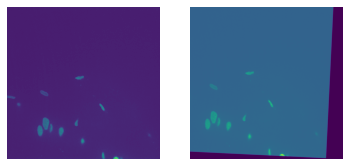

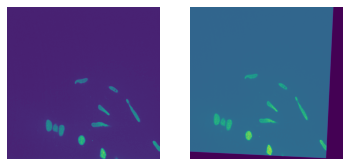

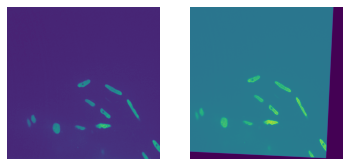

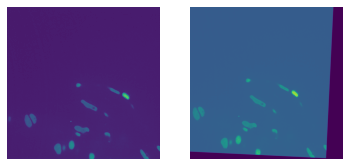

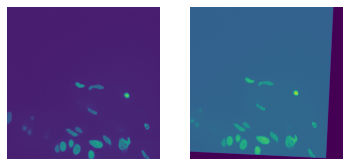

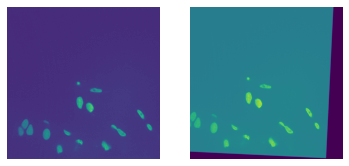

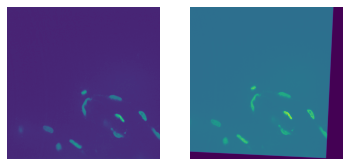

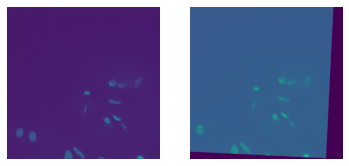

In [7]:
# View fixed volume and fixed volume with 3d deformation applied
for i in range(0, input.shape[0], 50):
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(input[i]);
    axarr[0].axis('off')
    axarr[1].imshow(output[0, 0, :, :, :][i]);
    axarr[1].axis('off')

In [ ]:
# Save as new .h5 file -- cast values to integers to reduce file size 
hf = h5py.File(f'synthetic_rigid_deformation.h5', 'w')
hf.create_dataset('fixed', data=input.numpy().astype(np.int16), compression='gzip')
hf.create_dataset('move', data=output[0, 0, :, :, :].numpy().astype(np.int16), compression='gzip')
hf.close()

### Non-rigid Deformation

In [4]:
# Create and apply 3d non-rigid deformation
# Right now, input and output will be the same size. You can adjust what size you want the output to be in deformation.py

output = non_rigid_deformation(input_path = path, num_of_parallel_porcesses = 10, gaussian_sigma = 60)

input shape torch.Size([1, 1, 385, 2048, 2048])
output shape torch.Size([1, 1, 385, 2048, 2048])


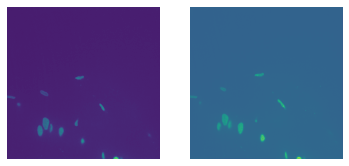

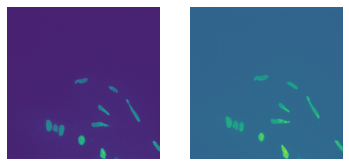

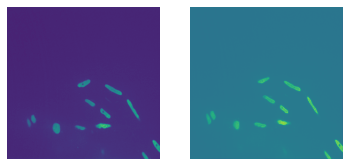

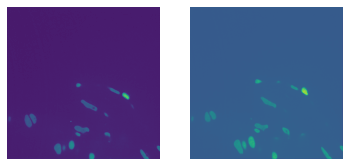

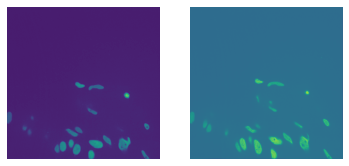

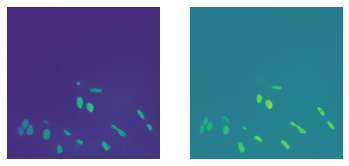

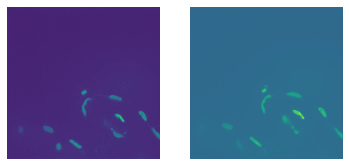

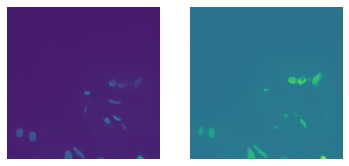

In [5]:
input = readH5(path=path)[0] # fixed volume

# View fixed volume and fixed volume with non-rigid deformation applied. 
# Adjust intensity of deformation in deformation.py. Intensity is mild for example pair. 
for i in range(0, input.shape[0], 50):
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(input[i]);
    axarr[0].axis('off')
    axarr[1].imshow(output[0, 0, i].numpy());
    axarr[1].axis('off')

In [6]:
# Save as new .h5 file -- cast values to integers to reduce file size 

hf = h5py.File(f'synthetic_nonrigid_deformation.h5', 'w')
hf.create_dataset('fixed', data=input.astype(np.int16), compression='gzip')
hf.create_dataset('move', data=output[0, 0, :, :, :].numpy().astype(np.int16), compression='gzip')
hf.close()